<h1 style="text-align:center;">Analysis of Feature Selection and Automatic Threshold in Classification Modeling:  A Case Study Using Body Performance Data</h1>
<hr style="border:2px solid gray">
<p>&nbsp;</p>

**This project aims to analyze and optimize classification modeling using automatic feature selection and threshold techniques**. The problem to be solved is how to select the most relevant and significant features in a given dataset, and **determine the optimal automatic threshold to improve the performance of the classification model**.

The **goal** of this project is to present a comprehensive approach to selecting relevant features and **determining the optimal automatic threshold in classification modeling**. The approach includes using **two different feature selection methods, namely MRMR (Minimum Redundancy Maximum Relevance) and ReliefF**, to obtain the most informative subset of features in the dataset. In addition, I will explain the use of the **Maximum Fisher's Discriminant Ratio (F1) method to determine the optimal automatic threshold**.

By combining these two techniques, it is **hoped that this report can provide a better understanding of feature selection and the use of automatic thresholds in classification modeling**. Through **training using the Random Forest Classifier algorithm and evaluation**, the accuracy of the model obtained after performing feature selection and the use of automatic threshold will also be measured.

In [21]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_regression
from matplotlib import pyplot as plt

## Data Used
Data Source: 
- Dataset Name: Body Performance Data
- Source: Kaggle (https://www.kaggle.com/datasets/kukuroo3/body-performance-data)
- Description: This is data that confirms a person's performance level(Grade)/fitness with some features such as age and some performance data in sports that have 4 target classes.

Statistical Data Used:
- Total Data: 13392 samples
- Target Variables: A,B,C,D (A: best, B: less best, C: good, D: less good)
- Number of Columns: 11 Features & 1 Target

In [2]:
# read dataset
df = pd.read_csv('bodyPerformance.csv')

# Delete duplicate rows
df = df.drop_duplicates()
print(df.shape)

(13392, 12)


In [3]:
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


##### Mapping labels

In [4]:
# Mapping labels 'A', 'B', 'C', 'D' to numeric values 0, 1, 2, 3
label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
df['class'] = df['class'].replace(label_mapping)

# Mapping labels 'M' and 'F' to numeric values 1 and 2
label_mapping = {'M': 1, 'F': 2}
df['gender'] = df['gender'].replace(label_mapping)

In [5]:
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,1,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,2
1,25.0,1,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0
2,31.0,1,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,2
3,32.0,1,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,1
4,28.0,1,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,1


##### Split dataset & StandardScaler

In [23]:
# Split the dataset, features(X) and target(y)
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1])

X_col = df.iloc[:, :-1].columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the dataset
scaler.fit(X)

# Transform the dataset using the scaler
X_std = scaler.transform(X)

df_X_std = pd.DataFrame(data=X_std, columns=X_col)
df_X_std.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,-0.717473,-0.762673,0.443785,0.652068,-0.267290,0.111946,-0.016189,1.688110,0.377347,1.417000,0.673949
1,-0.864258,-0.762673,-0.422582,-0.974898,-1.039006,-0.167337,-0.288131,-0.053138,0.129020,0.926679,0.974946
2,-0.423903,-0.762673,1.310152,0.883058,-0.432658,1.229081,1.479495,0.737483,-0.379460,0.646496,-0.229043
3,-0.350510,-0.762673,0.704882,0.305585,-0.666929,-0.260432,1.139567,0.417470,-0.001056,0.926679,0.724115
4,-0.644080,-0.762673,0.621806,0.021033,-0.846077,-0.818999,-0.220146,0.615125,1.406131,0.366313,0.673949


## Feature Selection Method
K or the maximum number of features selected is fixed at 3 & 6 because I try to use a fraction of the total features and half of the total features.

### MRMR (Minimum Redundancy Maximum Relevance)

The MRMR (Minimum Redundancy Maximum Relevance) algorithm is a feature selection method that aims to select a subset of features that have **maximum correlation with the target (maximum relevance)** and **minimum correlation between those features (minimum redundancy)**. This algorithm combines two important concepts in feature selection, namely **relevance and redundancy**. MRMRe tries to find features that are **highly informative** and at the same time **distinct from each other**. So, if feature A and feature B are both relevant, but both carry **more or less the same information**, the minimal optimal method will only select one of them and discard the other.

The way MRMR works is that at each iteration the algorithm will select features that have **maximum relevance to the target variable** and **minimum redundancy to the features that have been selected in the previous iteration**.

In [24]:
# inputs:
#    X: pandas.DataFrame, features
#    y: pandas.Series, target variable
#    K: number of features to select
def min_redun_max_relev(X, y, k):
    # compute F-statistics and initialize correlation matrix
    F = pd.Series(f_regression(X, y)[0], index = X.columns)
    corr = pd.DataFrame(.00001, index = X.columns, columns = X.columns)

    # initialize list of selected features and list of excluded features
    selected = []
    not_selected = X.columns.to_list()

    # initialize list of feature scores
    scores = []
    scores_ith = []

    redundancy = []
    relevancy = []
    # repeat K times
    for i in range(k):
        # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
        if i > 0:
            last_selected = selected[-1]
            corr.loc[not_selected, last_selected] = X[not_selected].corrwith(X[last_selected]).abs().clip(.00001)

        # compute FCQ score for all the (currently) excluded features (this is Formula 2)
        score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)
        relevancy.append(F.loc[not_selected])
        redundancy.append(corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001))

        scores_ith.append(score)
        # find best feature, add it to selected and remove it from not_selected
        best = score.index[score.argmax()]
        selected.append(best)
        not_selected.remove(best)

        # add feature name and score to list of feature scores
        scores.append((best, score[best]))
        
    # create DataFrame of feature scores
    score_df = pd.DataFrame(scores, columns=['mRMR', 'Highest_score_each_iteration'])
    return scores,selected,scores_ith,score_df,relevancy,redundancy  

In [26]:
# Define the range of values for k
len_row, len_col = X.shape
k_values = range(1, len_col+1)

# Initialize dictionaries to store results
selected_each_k = {}

for k in k_values:
    scores, selected, scores_ith, score_df, relevancy, redundancy = min_redun_max_relev(df_X_std, y, k)
    selected_each_k[f'k = {k}'] = selected

#### How MRMR works?
The following is the calculation of each iteration up to all features.
 
The first iteration selected 'sit and bend forward_cm' because it has the highest MRMR score,
 
By removing 'sit and bend forward_cm', the second iteration selected 'broad jump_cm', etc. The best to worst feature results were obtained.

In [27]:
for i in range(len(scores_ith)):
    combines = {'Relevancy':relevancy[i], 'Redundancy':redundancy[i],'MRMR':scores_ith[i]}
    scored_ith = pd.DataFrame(combines)
    scored_ith = scored_ith.sort_values('MRMR', ascending=False)
    print(i+1,' iteration')
    print(scored_ith)
    print()
    print()

1  iteration
                           Relevancy  Redundancy          MRMR
sit and bend forward_cm  7080.232375     0.00001  7.080232e+08
sit-ups counts           3453.239895     0.00001  3.453240e+08
body fat_%               1774.716607     0.00001  1.774717e+08
broad jump_cm             988.769614     0.00001  9.887696e+07
weight_kg                 642.688746     0.00001  6.426887e+07
gripForce                 253.040526     0.00001  2.530405e+07
gender                     76.729646     0.00001  7.672965e+06
diastolic                  59.809699     0.00001  5.980970e+06
age                        57.774806     0.00001  5.777481e+06
height_cm                  18.977819     0.00001  1.897782e+06
systolic                   16.608674     0.00001  1.660867e+06


2  iteration
                  Relevancy  Redundancy          MRMR
broad jump_cm    988.769614    0.026511  37296.454312
body fat_%      1774.716607    0.071269  24901.493411
sit-ups counts  3453.239895    0.177128  19495.720522


In [28]:
# Find the maximum number of values across all keys
max_values = max([len(val) if isinstance(val, list) else 1 for val in selected_each_k.values()])

# Iterate through the keys and add "n/a" values as necessary
for key, val in selected_each_k.items():
    # Check if the value is a string and split by comma if necessary
    if isinstance(val, str):
        values = val.split(',')
    else:
        values = val
        
    # If the number of values is less than the maximum, add "n/a" values
    num_values = len(values)
    if num_values < max_values:
        diff = max_values - num_values
        values += ['-'] * diff
    
    # Join the values with commas and update the dictionary
    selected_each_k[key] = values
    
selected_each_k_df = pd.DataFrame(selected_each_k)

#### Table selected each k

In [29]:
selected_each_k_df.iloc[:, :].head(100)

,k = 1,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,k = 9,k = 10,k = 11
0,sit and bend forward_cm,sit and bend forward_cm,sit and bend forward_cm,sit and bend forward_cm,sit and bend forward_cm,sit and bend forward_cm,sit and bend forward_cm,sit and bend forward_cm,sit and bend forward_cm,sit and bend forward_cm,sit and bend forward_cm
1,-,broad jump_cm,broad jump_cm,broad jump_cm,broad jump_cm,broad jump_cm,broad jump_cm,broad jump_cm,broad jump_cm,broad jump_cm,broad jump_cm
2,-,-,sit-ups counts,sit-ups counts,sit-ups counts,sit-ups counts,sit-ups counts,sit-ups counts,sit-ups counts,sit-ups counts,sit-ups counts
3,-,-,-,body fat_%,body fat_%,body fat_%,body fat_%,body fat_%,body fat_%,body fat_%,body fat_%
4,-,-,-,-,weight_kg,weight_kg,weight_kg,weight_kg,weight_kg,weight_kg,weight_kg
5,-,-,-,-,-,diastolic,diastolic,diastolic,diastolic,diastolic,diastolic
6,-,-,-,-,-,-,gripForce,gripForce,gripForce,gripForce,gripForce
7,-,-,-,-,-,-,-,age,age,age,age
8,-,-,-,-,-,-,-,-,gender,gender,gender
9,-,-,-,-,-,-,-,-,-,systolic,systolic


After running the MRMR algorithm on the given dataset, the best feature subset is obtained that has a high relevance value to the target and a low level of redundancy between the features. 

So, here are the results of MRMR feature selection with **k=3** with **k=6**

### ReliefF

The ReliefF algorithm is a **popular feature selection method** in classification problems. The goal is to identify the most **informative features** by considering their effect on **class separation** in the data. ReliefF is a feature selection algorithm that ranks features based on how well they can distinguish between **instances that are close to each other**. 

It randomly selects an instance and finds its **k-nearest neighbors from the same class (hits)** and **k-nearest neighbors from different classes (misses)**. It then updates the feature weights by comparing the instance's feature values with the **hits and misses**. Feature weights that have **different values for instances and misses will be rewarded or increased**, while features that have **different values for instances and hits will be penalized or decreased**.

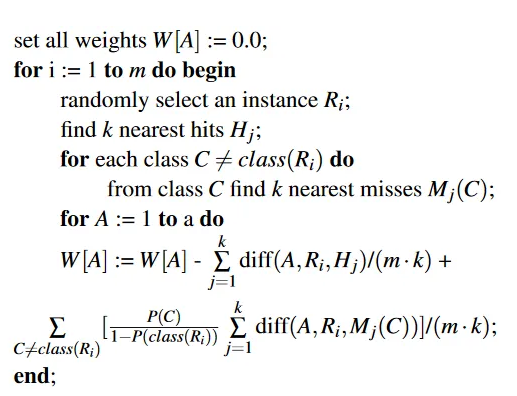

In [18]:
def reliefF(X, y, k_neighbors=3):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)  # Initialize feature weights
    
    # Calculate class probabilities (how often each class occurs)
    class_probs = np.bincount(y) / len(y)
    
    # Calculate the maximum and minimum values for each feature
    max_val = np.max(X, axis=0)
    min_val = np.min(X, axis=0)
    
    m = n_samples  # Total number of samples
    
    selected_indices = []  # Initialize an empty list to store selected sample indices
    
    for i in range(m):
        # Find indices of samples that have not been selected
        valid_indices = np.setdiff1d(np.arange(n_samples), selected_indices)
        
        # Choose a random index from the remaining valid indices
        random_index = np.random.choice(valid_indices)
        
        # Add the selected index to the list of selected indices
        selected_indices.append(random_index)
        
        # Calculate distances between the selected sample and all other samples
        distances = np.sum(np.abs(X - X[random_index]), axis=1)
        
        # Sort distances and find indices of nearest neighbors
        nearest_indices = np.argsort(distances)
        
        # Find nearest neighbors with the same class label as the selected sample
        nearest_same_class = nearest_indices[(y[nearest_indices] == y[random_index]) & (nearest_indices != random_index)][:k_neighbors]
        
        # Find nearest neighbors with different class labels from the selected sample
        nearest_diff_class = nearest_indices[(y[nearest_indices] != y[random_index])][:k_neighbors]
        
        for j in range(n_features):
            # Calculate ReliefF weights for features based on nearest neighbors
            
            # ReliefF weight for features with the same class
            nearest_same_dist = distances[nearest_same_class]
            maxmin = (max_val[j] - min_val[j]) if (max_val[j] - min_val[j]) != 0 else 1
            weights_same = (np.abs(X[random_index, j] - X[nearest_same_class, j]) / maxmin)
            weights[j] -= (np.sum(weights_same) / (k_neighbors * m))
            
            # ReliefF weight for features with different classes
            weights_diff = 0
            for C, class_prob in enumerate(class_probs):
                if C != y[random_index]:
                    miss_prob = (class_prob / (1 - class_probs[y[random_index]]))
                    nearest_diff_dist = distances[nearest_diff_class]
                    miss_weight = np.abs(X[random_index, j] - X[nearest_diff_class, j])
                    weights_diff += (miss_prob * np.sum(miss_weight) / (k_neighbors * m))
            
            weights[j] += (weights_diff / (k_neighbors * m))
    
    return weights


In [30]:
# Assuming X_std and y are defined
feature_weights = reliefF(X_std, y)

combines = {'Features': df.iloc[:, :-1].columns, 'Weights': feature_weights}
weight_f = pd.DataFrame(combines)
weight_f = weight_f.sort_values('Weights', ascending=False)

#### Weight of each feature
After running the ReliefF algorithm on the given dataset, the feature weights for each feature in the dataset are obtained. Features with high weights are considered more informative and contribute more to separating classes in the data. The following is the weight of each feature,

In [31]:
weight_f = weight_f.sort_values('Weights', ascending=False)
weight_f.head(100)

,Features,Weights
1,gender,-0.001220
8,sit and bend forward_cm,-0.010361
5,diastolic,-0.021041
6,systolic,-0.021937
4,body fat_%,-0.027585
3,weight_kg,-0.028426
2,height_cm,-0.034446
10,broad jump_cm,-0.035407
7,gripForce,-0.040222
9,sit-ups counts,-0.048126


So, here are the results of ReliefF feature selection with **k=3** with **k=6**



### Automatic Threshold with Maximum Fisher's Discriminant Ratio (F1)
**Automatic Threshold with Maximum Fisher's Discriminant Ratio (F1)** is a method for automatically selecting thresholds in classification modeling. The concept of **(F1)** is based on statistical analysis and measurement of significant differences between two groups of different classes.

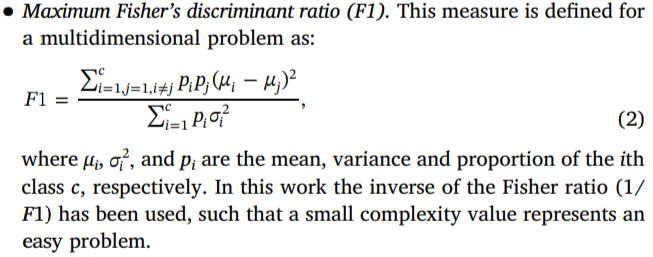
The calculation process with F1:
1.	Calculate the mean, variance, and proportion of each class in the dataset.
2.	Apply the **F1 formula** to calculate the **F1 value (Fisher's discriminant ratio)**. The F1 value is the result of division between the numerator and denominator.
3.	The numerator is calculated by summing up all the different combinations of classes, multiplying by the proportion of the class, multiplying by the square of the mean difference of the class.
4.	The denominator is calculated by summing all class proportions, multiplied by the variance of the class.
5.	The **F1 score** result shows the **F1 value** obtained.

In [32]:
def calculate_F1(X, y):
    c = len(np.unique(y))  # Number of classes
    means = np.zeros(c)  # Array to store means of each class
    variances = np.zeros(c)  # Array to store variances of each class
    proportions = np.zeros(c)  # Array to store proportions of each class
    
    # Calculate means, variances, and proportions of each class
    for i in range(c):
        means[i] = np.mean(X[y == i])
        
        variances[i] = np.var(X[y == i])
        
        proportions[i] = np.sum(y == i) / len(y)
    numerator = 0.0
    denominator = 0.0

    # Calculate numerator and denominator of F1
    for i in range(c):
        for j in range(c):
            if i != j:
                numerator += proportions[i] * proportions[j] * (means[i] - means[j]) ** 2

        denominator += proportions[i] * variances[i]
    F1 = numerator / denominator
    return F1

# Calculating the F1 score
F1_score = calculate_F1(X_std, y)

print("Maximum Fisher's discriminant ratio (F1):", F1_score)

Maximum Fisher's discriminant ratio (F1): 0.009551998997520652


After the calculation, the **Maximum Fisher's Discriminant Ratio (F1) value is obtained: 0.009551998997520652**. The F1 score value generated from the calculation shows how well the threshold separates the different classes in the dataset. The higher the F1 score value, the better the threshold is in distinguishing the classes.

The value of **Maximum Fisher's Discriminant Ratio** can only be used on the results of **ReliefF selection features** that have weights, while **MRMR selection features** cannot be thresholded because they do not have definite weights and only have different MRMR values for each iteration.

Before being applied to the **ReliefF selection feature results**, the weights are first **normalized** to have a range of 0 - 1 because the **F1 value** also has a range of 0 - 1. The following are the ReliefF selection feature results, weights, and normalization results.

In [34]:
def normalize_dataframe(df):
    # Find the minimum and maximum values in the dataframe
    min_val = df.min().min()
    max_val = df.max().max()
    
    # Normalize the dataframe using the formula: normalized_value = (value - min_val) / (max_val - min_val)
    normalized_df = (df - min_val) / (max_val - min_val)
    
    # Invert the normalization to have the maximum value as 0 and the minimum value as 1
    inverted_df = normalized_df
    
    return inverted_df

# Normalize the F1 values using Min-Max scaling
weight_f_norm = weight_f
weight_f_norm['Normalized'] = normalize_dataframe(weight_f[['Weights']])
weight_f_norm.head(100)

,Features,Weights,Normalized
1,gender,-0.001220,1.000000
8,sit and bend forward_cm,-0.010361,0.878533
5,diastolic,-0.021041,0.736632
6,systolic,-0.021937,0.724730
4,body fat_%,-0.027585,0.649684
3,weight_kg,-0.028426,0.638502
2,height_cm,-0.034446,0.558522
10,broad jump_cm,-0.035407,0.545750
7,gripForce,-0.040222,0.481770
9,sit-ups counts,-0.048126,0.376742


So, by applying the value **F1: 0.009551998997520652**, the selected feature is **all features except feature `age`**.

## Training and Model Evaluation
The data used is divided into two subsets, namely **training data (training set) of 70%** and **testing data (testing set) of 30%**. After the features are selected through the selection process mentioned earlier, the next step is to train the model using the **Random Forest Classifier algorithm**. There are six kinds of training and evaluation to be done; **using all features, MRMR k=3 & k=6 selection feature results, ReliefF k=3 & k=6 selection feature results, ReliefF selection feature results and Threshold Maximum Fisher's Discriminant Ratio**.
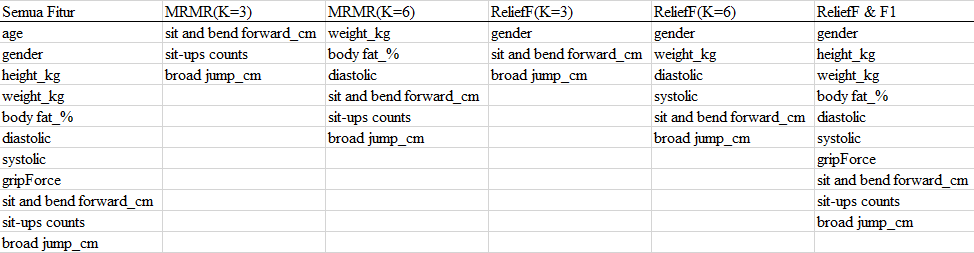

Once the training is complete, the trained model is evaluated using appropriate evaluation metrics to obtain information about the model's performance. Some commonly used **evaluation metrics in classification** are:
* Accuracy: The ratio of correct classifications to total classifications.
* Also used is `Time` to measure the length of training.

In [36]:
Xs = df.iloc[:, :-1]
ys = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size = 0.3, random_state = 42)

accs = {}
timer = {}

#### All Column

In [37]:
start_time = time.time()
# Train a random forest model on the training data
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)
end_time = time.time()

# Evaluate the model on the testing data
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
times = end_time - start_time

print(f"Accuracy = {acc}")
print(f"Elapsed Time = {times}")

Accuracy = 0.7336983573917372
Elapsed Time = 2.615046262741089


#### MRMR(K=3)

In [38]:
X_select = X_train[['sit and bend forward_cm','sit-ups counts','broad jump_cm']]

start_time = time.time()
# Train a random forest model on the training data
model = RandomForestClassifier(random_state = 42)
model.fit(X_select, y_train)
end_time = time.time()

# Evaluate the model on the testing data
X_test_select = X_test[['sit and bend forward_cm','sit-ups counts','broad jump_cm']]
y_pred = model.predict(X_test_select)
acc = accuracy_score(y_test, y_pred)

times = end_time - start_time

print(f"Accuracy = {acc}")
print(f"Elapsed Time = {times}")
print()

Accuracy = 0.5567446490791439
Elapsed Time = 1.4532577991485596



#### MRMR(K=6)

In [39]:
X_select = X_train[['weight_kg','body fat_%','diastolic','sit and bend forward_cm','sit-ups counts','broad jump_cm']]

start_time = time.time()
# Train a random forest model on the training data
model = RandomForestClassifier(random_state = 42)
model.fit(X_select, y_train)
end_time = time.time()

# Evaluate the model on the testing data
X_test_select = X_test[['weight_kg','body fat_%','diastolic','sit and bend forward_cm','sit-ups counts','broad jump_cm']]
y_pred = model.predict(X_test_select)
acc = accuracy_score(y_test, y_pred)

times = end_time - start_time

print(f"Accuracy = {acc}")
print(f"Elapsed Time = {times}")
print()

Accuracy = 0.6199601791936287
Elapsed Time = 2.1289541721343994



#### ReliefF(K=3)

In [40]:
X_select = X_train[['gender','sit and bend forward_cm','broad jump_cm']]

start_time = time.time()
# Train a random forest model on the training data
model = RandomForestClassifier(random_state = 42)
model.fit(X_select, y_train)
end_time = time.time()

# Evaluate the model on the testing data
X_test_select = X_test[['gender','sit and bend forward_cm','broad jump_cm']]
y_pred = model.predict(X_test_select)
acc = accuracy_score(y_test, y_pred)

times = end_time - start_time

print(f"Accuracy = {acc}")
print(f"Elapsed Time = {times}")
print()

Accuracy = 0.485813837730214
Elapsed Time = 1.4732890129089355



#### ReliefF(K=6)

In [41]:
X_select = X_train[['gender','weight_kg','diastolic','systolic','sit and bend forward_cm','broad jump_cm']]

start_time = time.time()
# Train a random forest model on the training data
model = RandomForestClassifier(random_state = 42)
model.fit(X_select, y_train)
end_time = time.time()

# Evaluate the model on the testing data
X_test_select = X_test[['gender','weight_kg','diastolic','systolic','sit and bend forward_cm','broad jump_cm']]
y_pred = model.predict(X_test_select)
acc = accuracy_score(y_test, y_pred)

times = end_time - start_time

print(f"Accuracy = {acc}")
print(f"Elapsed Time = {times}")
print()

Accuracy = 0.566948730711797
Elapsed Time = 2.098485231399536



#### ReliefF & Maximum Fisher's Discriminant Ratio

In [42]:
X_select = X_train.drop('age',axis=1)

start_time = time.time()
# Train a random forest model on the training data
model = RandomForestClassifier(random_state = 42)
model.fit(X_select, y_train)
end_time = time.time()

# Evaluate the model on the testing data
X_test_select = X_test.drop('age',axis=1)
y_pred = model.predict(X_test_select)
acc = accuracy_score(y_test, y_pred)

times = end_time - start_time

print(f"Accuracy = {acc}")
print(f"Elapsed Time = {times}")
print()

Accuracy = 0.6518168242906919
Elapsed Time = 2.4416184425354004



##### Model Accuracy:
- Using all features gives the highest accuracy of 0.7337.
- When using the MRMR method with K=3, the accuracy decreased to 0.5567. This shows that by using the MRMR method, I retain the features that are most relevant to the classification target, but the number is limited and sacrifices some of the model accuracy.
- With MRMR and K=6, the accuracy increased slightly to 0.6199, which shows that more relevant features were retained, but there was still a reduction in accuracy compared to using all features.
- The ReliefF method with K=3 resulted in a lower accuracy of 0.4858. This shows that ReliefF tends to retain different features than MRMR, but perhaps some of the retained features are less relevant to the classification target.
- With ReliefF and K=6, the accuracy slightly increases to 0.5669, which indicates that retaining more features with ReliefF improves performance compared to ReliefF and K=3.
- The combination of ReliefF with F1 score gave the best accuracy of 0.6518. This suggests that using ReliefF with F1 score in mind can produce a better subset of features to maximize model performance.


##### Training Time:
- The training time of the model was also evaluated to see the efficiency of using the feature selection method.
- Using all features requires the longest training time.
- The MRMR method with K=3 gives a faster training time, indicating that feature selection with MRMR is more efficient in terms of time.
- With MRMR and K=6, the training time increases, but it is still faster than using all features.
- The ReliefF method with K=3 gives the fastest training time, showing the efficiency of ReliefF in feature selection.
- With ReliefF and K=6, the training time increases, but is still faster than using all features.
- Using ReliefF with F1 score requires the longest training time, which may be due to the additional calculations to consider F1 score.


## Conclusion
I conducted an analysis of feature selection and automatic threshold usage in classification modeling. I used MRMR and ReliefF methods for feature selection, and Maximum Fisher Discriminant Ratio (F1) for automatic threshold. I also took into account the model evaluation results based on accuracy and training time.
My main findings are as follows:
1.	The MRMR method can be used to retain a subset of features that are most relevant to the classification target. However, by limiting the number of features, the accuracy of the model may decrease.
2.	The ReliefF method provides flexibility in feature selection by retaining different features than MRMR. However, using ReliefF with K=3 can reduce the accuracy of the model, while ReliefF with K=6 provides better performance.
3.	The combination of ReliefF with F1 score can produce an optimal feature subset in terms of model performance. The selection of features considered by maximizing F1 score can significantly improve model accuracy.
4.	The use of automatic threshold with Maximum Fisher Discriminant Ratio (F1) can simplify the threshold selection process in classification modeling. This can reduce the need to set the threshold manually, increasing efficiency and ease of use.